# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

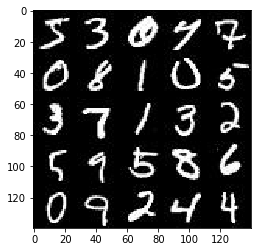

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

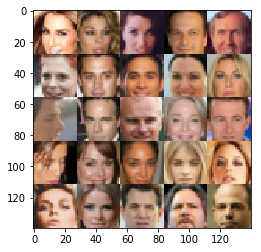

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Anaconda2\envs\tflearn\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name='input_real' )
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
    # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = True
    alpha = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)  #512
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))  #512
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')  #256
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 7x7x256 now
        
# x2:  Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
        
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
#         print("x3: ", x3)      
#         # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
#         # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True) 
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
%%time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("data shape1: ",data_shape[1])
    print("data shape2: ",data_shape[2])
    print("data shape3: ",data_shape[3])
    print("z dim: ",z_dim)    

#     tf.reset_default_graph()

    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)    
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, l_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 2, input_z, data_shape[3], data_image_mode)

    
    return losses                
                
                

Wall time: 0 ns


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data shape1:  28
data shape2:  28
data shape3:  1
z dim:  64
Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 15.8249
Epoch 1/2... Discriminator Loss: 2.2403... Generator Loss: 0.1487
Epoch 1/2... Discriminator Loss: 2.1184... Generator Loss: 0.1917
Epoch 1/2... Discriminator Loss: 1.8634... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 2.1341... Generator Loss: 0.1740
Epoch 1/2... Discriminator Loss: 1.8165... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.3047
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.2789
Epoch 1/2... Discriminator Loss: 1.6461... Generator Loss: 0.2559


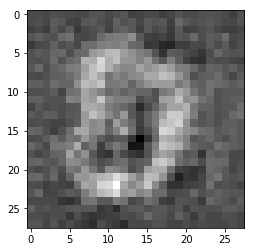

Epoch 1/2... Discriminator Loss: 1.6549... Generator Loss: 0.2591
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 0.3232... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 0.1759... Generator Loss: 2.1494
Epoch 1/2... Discriminator Loss: 0.0805... Generator Loss: 3.7029
Epoch 1/2... Discriminator Loss: 0.0491... Generator Loss: 3.3985


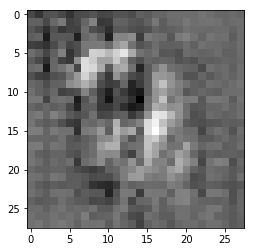

Epoch 1/2... Discriminator Loss: 0.0360... Generator Loss: 3.8211
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 5.6576
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 2.9862
Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 1.5989
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 2.4133
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 2.8687
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 2.0616
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 0.6493


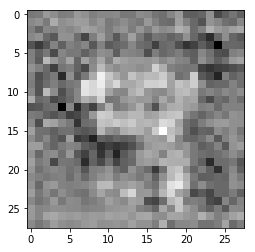

Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 4.5448
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 0.1136... Generator Loss: 2.7236
Epoch 1/2... Discriminator Loss: 0.0636... Generator Loss: 5.0374
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.7723... Generator Loss: 5.8014
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 1.9395
Epoch 1/2... Discriminator Loss: 0.1596... Generator Loss: 2.1390
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 3.4681
Epoch 1/2... Discriminator Loss: 0.0836... Generator Loss: 3.0108


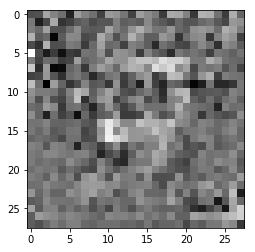

Epoch 1/2... Discriminator Loss: 0.1677... Generator Loss: 2.4762
Epoch 1/2... Discriminator Loss: 0.0199... Generator Loss: 4.7967
Epoch 1/2... Discriminator Loss: 1.9690... Generator Loss: 4.8490
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 1.8571
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 1.6039... Generator Loss: 0.3314
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 4.8929
Epoch 1/2... Discriminator Loss: 1.6534... Generator Loss: 0.2900
Epoch 1/2... Discriminator Loss: 0.0502... Generator Loss: 3.7856


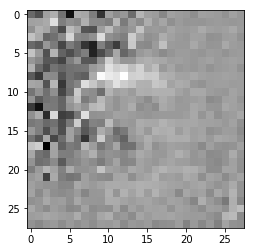

Epoch 1/2... Discriminator Loss: 0.1597... Generator Loss: 2.4432
Epoch 1/2... Discriminator Loss: 0.0825... Generator Loss: 3.1409
Epoch 1/2... Discriminator Loss: 0.0362... Generator Loss: 5.4774
Epoch 1/2... Discriminator Loss: 0.1451... Generator Loss: 2.3899
Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 0.0157... Generator Loss: 6.6220
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 0.1885... Generator Loss: 2.5802
Epoch 1/2... Discriminator Loss: 0.2388... Generator Loss: 1.8679


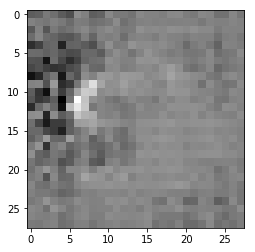

Epoch 1/2... Discriminator Loss: 0.1947... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 0.2387... Generator Loss: 1.8728
Epoch 1/2... Discriminator Loss: 4.4342... Generator Loss: 2.2902
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.9700
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 2.3040
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.4821
Epoch 1/2... Discriminator Loss: 0.2266... Generator Loss: 2.3150
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 1.6867
Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 2.7915
Epoch 1/2... Discriminator Loss: 0.0746... Generator Loss: 3.2087


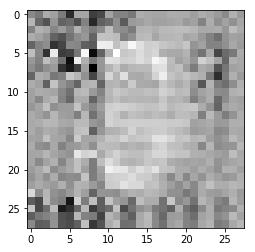

Epoch 1/2... Discriminator Loss: 0.0997... Generator Loss: 2.8375
Epoch 1/2... Discriminator Loss: 0.0667... Generator Loss: 3.3081
Epoch 1/2... Discriminator Loss: 0.0184... Generator Loss: 5.4949
Epoch 1/2... Discriminator Loss: 0.0299... Generator Loss: 4.2650
Epoch 1/2... Discriminator Loss: 0.0106... Generator Loss: 7.2908
Epoch 1/2... Discriminator Loss: 0.0368... Generator Loss: 4.0477
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 1.1195
Epoch 1/2... Discriminator Loss: 2.2275... Generator Loss: 0.1660
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.4431
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.0757


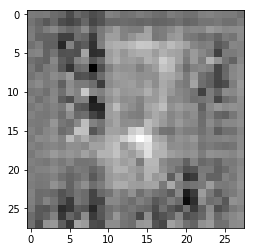

Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 1.6180
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 1.7879
Epoch 1/2... Discriminator Loss: 0.0936... Generator Loss: 3.0370
Epoch 1/2... Discriminator Loss: 0.0495... Generator Loss: 4.2105
Epoch 1/2... Discriminator Loss: 0.0576... Generator Loss: 3.3940
Epoch 1/2... Discriminator Loss: 3.3299... Generator Loss: 0.0525
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 0.1696... Generator Loss: 2.2914
Epoch 1/2... Discriminator Loss: 0.1022... Generator Loss: 3.0748
Epoch 1/2... Discriminator Loss: 0.2392... Generator Loss: 1.9483


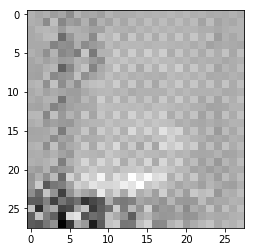

Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 2.5450
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 1.6813
Epoch 1/2... Discriminator Loss: 0.1650... Generator Loss: 2.6984
Epoch 2/2... Discriminator Loss: 0.0781... Generator Loss: 3.7114
Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 4.6459
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 3.6029
Epoch 2/2... Discriminator Loss: 0.0351... Generator Loss: 4.2956
Epoch 2/2... Discriminator Loss: 0.0717... Generator Loss: 3.4918
Epoch 2/2... Discriminator Loss: 0.0707... Generator Loss: 3.1688
Epoch 2/2... Discriminator Loss: 0.0138... Generator Loss: 6.1115


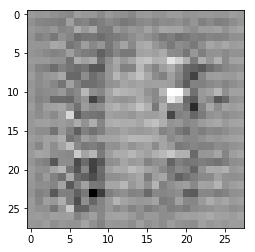

Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 6.4562
Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 4.2596
Epoch 2/2... Discriminator Loss: 0.0061... Generator Loss: 7.7077
Epoch 2/2... Discriminator Loss: 0.0085... Generator Loss: 5.8254
Epoch 2/2... Discriminator Loss: 0.0089... Generator Loss: 5.8032
Epoch 2/2... Discriminator Loss: 0.0049... Generator Loss: 7.1582
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 2.9680
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 3.5313
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 2.5708
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 1.3980


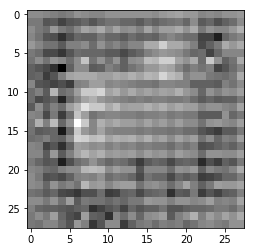

Epoch 2/2... Discriminator Loss: 0.3031... Generator Loss: 1.7876
Epoch 2/2... Discriminator Loss: 0.2286... Generator Loss: 2.1392
Epoch 2/2... Discriminator Loss: 0.1113... Generator Loss: 3.3387
Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 2.8574
Epoch 2/2... Discriminator Loss: 0.0650... Generator Loss: 3.7132
Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 4.0649
Epoch 2/2... Discriminator Loss: 0.0500... Generator Loss: 3.7847
Epoch 2/2... Discriminator Loss: 0.1412... Generator Loss: 4.5558
Epoch 2/2... Discriminator Loss: 2.4646... Generator Loss: 3.5000
Epoch 2/2... Discriminator Loss: 1.6185... Generator Loss: 2.6031


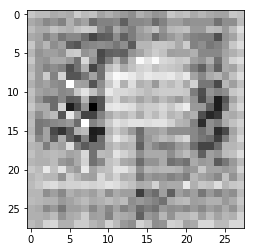

Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 2.1880
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 2.8433
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 2.8832
Epoch 2/2... Discriminator Loss: 0.4116... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 0.1549... Generator Loss: 2.5904
Epoch 2/2... Discriminator Loss: 0.0786... Generator Loss: 3.2056
Epoch 2/2... Discriminator Loss: 0.1233... Generator Loss: 2.8346
Epoch 2/2... Discriminator Loss: 0.0394... Generator Loss: 4.1420
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 5.4209
Epoch 2/2... Discriminator Loss: 0.0343... Generator Loss: 4.2270


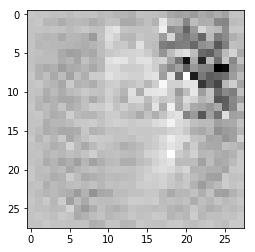

Epoch 2/2... Discriminator Loss: 0.0156... Generator Loss: 5.3065
Epoch 2/2... Discriminator Loss: 0.1747... Generator Loss: 2.1207
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 1.4085
Epoch 2/2... Discriminator Loss: 2.1435... Generator Loss: 0.1840
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 3.5167
Epoch 2/2... Discriminator Loss: 0.5707... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.4000
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 0.9093


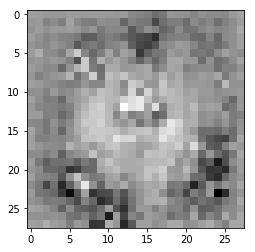

Epoch 2/2... Discriminator Loss: 0.3065... Generator Loss: 1.7507
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 0.0894... Generator Loss: 3.1393
Epoch 2/2... Discriminator Loss: 0.0586... Generator Loss: 3.6562
Epoch 2/2... Discriminator Loss: 0.0810... Generator Loss: 3.2933
Epoch 2/2... Discriminator Loss: 0.0985... Generator Loss: 2.9397
Epoch 2/2... Discriminator Loss: 0.0323... Generator Loss: 4.3880
Epoch 2/2... Discriminator Loss: 0.0287... Generator Loss: 4.4697
Epoch 2/2... Discriminator Loss: 0.0336... Generator Loss: 4.4250
Epoch 2/2... Discriminator Loss: 0.0195... Generator Loss: 4.7621


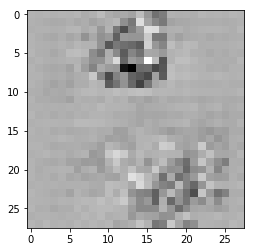

Epoch 2/2... Discriminator Loss: 0.0183... Generator Loss: 5.4070
Epoch 2/2... Discriminator Loss: 0.0129... Generator Loss: 5.4166
Epoch 2/2... Discriminator Loss: 0.0135... Generator Loss: 4.9332
Epoch 2/2... Discriminator Loss: 0.0141... Generator Loss: 5.2707
Epoch 2/2... Discriminator Loss: 0.0106... Generator Loss: 5.8930
Epoch 2/2... Discriminator Loss: 0.0626... Generator Loss: 4.9628
Epoch 2/2... Discriminator Loss: 1.7139... Generator Loss: 0.2726
Epoch 2/2... Discriminator Loss: 0.2146... Generator Loss: 2.0020
Epoch 2/2... Discriminator Loss: 0.3235... Generator Loss: 1.6160
Epoch 2/2... Discriminator Loss: 0.0896... Generator Loss: 2.9471


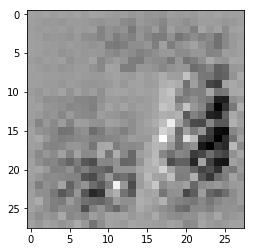

Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 3.6080
Epoch 2/2... Discriminator Loss: 0.1924... Generator Loss: 2.0415
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 3.6982
Epoch 2/2... Discriminator Loss: 0.0386... Generator Loss: 4.0152
Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 3.5305
Epoch 2/2... Discriminator Loss: 0.0213... Generator Loss: 4.7284
Epoch 2/2... Discriminator Loss: 0.0255... Generator Loss: 4.4341
Epoch 2/2... Discriminator Loss: 0.0190... Generator Loss: 4.5564
Epoch 2/2... Discriminator Loss: 0.0144... Generator Loss: 5.1009
Epoch 2/2... Discriminator Loss: 0.0148... Generator Loss: 5.4760


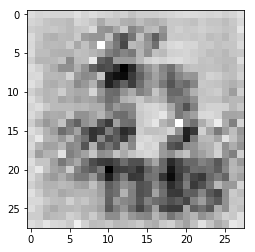

Epoch 2/2... Discriminator Loss: 0.0164... Generator Loss: 4.9430
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 5.4260
Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 3.1651
Epoch 2/2... Discriminator Loss: 0.0161... Generator Loss: 4.8398
Epoch 2/2... Discriminator Loss: 0.0050... Generator Loss: 6.5902
Epoch 2/2... Discriminator Loss: 0.0071... Generator Loss: 6.4908
Epoch 2/2... Discriminator Loss: 0.0215... Generator Loss: 4.5532
Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 0.7758


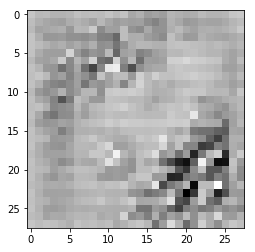

Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 1.6867
Epoch 2/2... Discriminator Loss: 1.5529... Generator Loss: 0.3429
Epoch 2/2... Discriminator Loss: 1.8185... Generator Loss: 0.2389
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 3.5589
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.3593
Epoch 2/2... Discriminator Loss: 0.3270... Generator Loss: 1.6667
Wall time: 1h 14min 6s


In [21]:
%%time

batch_size = 64 #None
z_dim = 64 #None
learning_rate = 0.001 #None
beta1 = 0.1 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.